In [91]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml

import pdcast as pdc

while not Path("data") in Path(".").iterdir():
    os.chdir("..")

import mscproject.features as feats
import mscproject.preprocess as pre
import mscproject.pygloaders as pgl
from mscproject.metrics import EvalMetrics
import catboost as cb

In [92]:
OPTUNA_DB = "sqlite:///data/optuna-03.db"
MODEL_DIR = Path("data/models")
PREDICTIONS_DIR = Path("data/predictions")

### CatBoost Paper: https://arxiv.org/pdf/1706.09516.pdf

In [93]:
# Read config.
conf_dict = yaml.safe_load(Path("config/conf.yaml").read_text())

features_path = conf_dict["features_path"]

In [94]:
# Load features for data split.
def load_features(path_root):
    companies_df = pd.read_parquet(conf_dict["companies_features"])
    persons_df = pd.read_parquet(conf_dict["persons_features"])
    return companies_df, persons_df

In [95]:
companies_df, persons_df = load_features(features_path)

In [96]:
companies_df.describe().T

,count,mean,std,min,25%,50%,75%,max
component,94054.0,2.025976e+03,2.262538e+03,0.000000,6.000000,1037.000000,3962.000000,6863.000000
indegree,94054.0,1.402386e+00,6.659484e-01,0.000000,1.000000,1.000000,2.000000,19.000000
outdegree,94054.0,5.733940e-01,3.103410e+00,0.000000,0.000000,0.000000,0.000000,460.000000
closeness,94054.0,1.405177e-05,6.167987e-06,0.000000,0.000008,0.000014,0.000016,0.000152
clustering,94054.0,5.096428e-03,4.470286e-02,0.000000,0.000000,0.000000,0.000000,1.000000
pagerank,94054.0,8.820028e-06,3.752041e-06,0.000006,0.000006,0.000007,0.000010,0.000090
neighbourhood_count,94054.0,1.364227e+00,2.981551e+00,1.000000,1.000000,1.000000,1.000000,460.000000
neighbourhood_indegree_min,94054.0,1.397431e+00,6.475961e-01,1.000000,1.000000,1.000000,2.000000,15.000000
neighbourhood_outdegree_min,94054.0,7.336211e-02,8.097613e-01,0.000000,0.000000,0.000000,0.000000,105.000000
neighbourhood_closeness_min,94054.0,1.492217e-05,6.417487e-06,0.000000,0.000011,0.000014,0.000018,0.000120


In [97]:
common_cols = set(companies_df.columns) & set(persons_df.columns)
drop_cols = ["id", "name", "component"]
select_cols = sorted(common_cols.difference(drop_cols))

target = "is_anomalous"

entities_df = pd.concat([companies_df, persons_df], axis=0)[list(common_cols)]

In [98]:
masks = pgl.get_data_split_masks(entities_df)

In [99]:
train_df = entities_df.loc[list(masks.train.numpy())].drop(drop_cols, axis=1)
valid_df = entities_df.loc[list(masks.val.numpy())].drop(drop_cols, axis=1)
test_df = entities_df.loc[list(masks.test.numpy())].drop(drop_cols, axis=1)

In [100]:
train_df

,neighbourhood_indegree_std,neighbourhood_closeness_max,neighbourhood_indegree_mean,neighbourhood_closeness_mean,outdegree,is_anomalous,neighbourhood_pagerank_max,neighbourhood_clustering_mean,neighbourhood_indegree_min,neighbourhood_outdegree_max,...,neighbourhood_closeness_sum,neighbourhood_outdegree_std,neighbourhood_pagerank_mean,pagerank,closeness,neighbourhood_outdegree_min,neighbourhood_pagerank_std,neighbourhood_indegree_sum,isCompany,neighbourhood_closeness_std
0,0.0,0.000021,2.0,0.000021,1,False,0.000012,0.0,2.0,0.0,...,0.000021,0.0,0.000012,0.000006,0.000008,0.0,0.000000e+00,2.0,True,0.000000
1,0.0,0.000011,1.0,0.000011,0,False,0.000007,0.0,1.0,0.0,...,0.000011,0.0,0.000007,0.000007,0.000011,0.0,0.000000e+00,1.0,True,0.000000
2,0.0,0.000008,1.0,0.000008,0,False,0.000007,0.0,1.0,0.0,...,0.000008,0.0,0.000007,0.000007,0.000008,0.0,0.000000e+00,1.0,True,0.000000
3,0.0,0.000016,2.0,0.000016,0,False,0.000011,0.0,2.0,0.0,...,0.000016,0.0,0.000011,0.000011,0.000016,0.0,0.000000e+00,2.0,True,0.000000
4,0.5,0.000031,2.5,0.000026,2,False,0.000015,0.0,2.0,0.0,...,0.000052,0.0,0.000014,0.000011,0.000016,0.0,1.383311e-06,5.0,True,0.000005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30875,0.5,0.000016,1.5,0.000012,2,False,0.000009,0.0,1.0,0.0,...,0.000024,0.0,0.000008,0.000006,0.000000,0.0,3.885234e-07,3.0,False,0.000004
30876,0.0,0.000024,3.0,0.000024,1,False,0.000016,0.0,3.0,1.0,...,0.000024,0.0,0.000016,0.000006,0.000000,1.0,0.000000e+00,3.0,False,0.000000
30877,0.0,0.000016,2.0,0.000016,1,False,0.000011,0.0,2.0,0.0,...,0.000016,0.0,0.000011,0.000006,0.000000,0.0,0.000000e+00,2.0,False,0.000000
30878,0.0,0.000008,1.0,0.000008,1,False,0.000010,0.0,1.0,6.0,...,0.000008,0.0,0.000010,0.000006,0.000000,6.0,0.000000e+00,1.0,False,0.000000


In [101]:
train_df.query("isCompany == False and indegree > 0")

,neighbourhood_indegree_std,neighbourhood_closeness_max,neighbourhood_indegree_mean,neighbourhood_closeness_mean,outdegree,is_anomalous,neighbourhood_pagerank_max,neighbourhood_clustering_mean,neighbourhood_indegree_min,neighbourhood_outdegree_max,...,neighbourhood_closeness_sum,neighbourhood_outdegree_std,neighbourhood_pagerank_mean,pagerank,closeness,neighbourhood_outdegree_min,neighbourhood_pagerank_std,neighbourhood_indegree_sum,isCompany,neighbourhood_closeness_std


In [102]:
# Create train, test, and valid pools for CatBoost.

cat_features = ["isCompany"]

X_train = train_df.drop(target, axis=1)
y_train = train_df[target].astype(np.int8)

X_val = valid_df.drop(target, axis=1)
y_val = valid_df[target].astype(np.int8)

X_test = test_df.drop(target, axis=1)
y_test = test_df[target].astype(np.int8)

In [103]:
train_pool = cb.Pool(
    X_train.to_numpy(),
    y_train.to_numpy(),
    cat_features=cat_features,
    feature_names=X_train.columns.to_list(),
)

val_pool = cb.Pool(
    X_val.to_numpy(),
    y_val.to_numpy(),
    cat_features=cat_features,
    feature_names=X_val.columns.to_list(),
)

trail_val_pool = cb.Pool(
    pd.concat([X_train, X_val]).to_numpy(),
    pd.concat([y_train, y_val]).to_numpy(),
    cat_features=cat_features,
    feature_names=X_test.columns.to_list(),
)

test_pool = cb.Pool(
    X_test.to_numpy(),
    y_test.to_numpy(),
    cat_features=cat_features,
    feature_names=X_test.columns.to_list(),
)

In [104]:
class_weights = {0: 1, 1: 10}

In [107]:
# Tune CatBoost model with Optuna.
import optuna


def objective(trial: optuna.Trial):

    params = {
        "objective": "Logloss",
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical(
            "boosting_type", ["Ordered", "Plain"]
        ),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "6gb",
        "class_weights": class_weights,
        "eval_metric": "PRAUC",
    }

    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    clf = cb.CatBoostClassifier(**params)

    clf.fit(
        train_pool,
        eval_set=val_pool,
        use_best_model=True,
        verbose=False,
    )

    best_iter = clf.get_best_iteration()
    if best_iter < 1:
        # Failed to train.
        raise optuna.TrialPruned()

    trial.set_user_attr("best_iter", best_iter)

    y_val_pred = clf.predict_proba(val_pool)[:, 1]
    eval_metrics = EvalMetrics.from_numpy(y_val_pred, y_val.to_numpy(), 10)

    return eval_metrics.average_precision


delete = False
if delete:
    optuna.delete_study(study_name="CATBOOST", storage=OPTUNA_DB)

# delete study
study = optuna.create_study(direction="maximize", study_name="CATBOOST", storage=OPTUNA_DB, load_if_exists=True)

n_trials = 20

completed_trials = len(study.get_trials(states=(optuna.trial.TrialState.COMPLETE,)))
remaining_trials = n_trials - completed_trials

study.optimize(objective, n_trials=remaining_trials)


[I 2022-09-18 02:23:24,959] Using an existing study with name 'CATBOOST' instead of creating a new one.


In [115]:
# Get best parameters.
best_params = study.best_params
user_attrs = study.best_trial.user_attrs

# Create CatBoost model.
clf = cb.CatBoostClassifier(
    iterations=1000,
    **best_params,
    class_weights=class_weights,
    random_seed=42,
    eval_metric="PRAUC",
)

# Fit model.
clf.fit(
    trail_val_pool,
    verbose=200,
)

# Print confusion matrix.
y_pred = clf.predict(test_pool)
print(pd.crosstab(y_test, y_pred, rownames=["Actual"], colnames=["Predicted"]))

# Evaluate model.
y_test_pred_proba = np.array([x[1] for x in clf.predict_proba(test_pool)])
eval_metrics = EvalMetrics.from_numpy(y_test_pred_proba, y_test.to_numpy())
print(eval_metrics)

# Store predictions.
predictions = pd.DataFrame(
    {
        "id": test_df.index,
        "pred_proba": y_test_pred_proba,
        "actual": y_test.to_numpy(),
    }
)
# predictions.to_csv(PREDICTIONS_DIR / "CatBoost.csv", index=False)

0:	learn: 0.7521503	total: 14.4ms	remaining: 14.4s
200:	learn: 0.6091841	total: 3.87s	remaining: 15.4s
400:	learn: 0.6052692	total: 7.73s	remaining: 11.5s
600:	learn: 0.6084785	total: 11.7s	remaining: 7.75s
800:	learn: 0.6086339	total: 15.4s	remaining: 3.83s
999:	learn: 0.6088676	total: 19.4s	remaining: 0us
Predicted     0     1
Actual               
0          2094  5006
1            63   499
loss: 0.693, acc: 0.927, prc: 0.091, rec: 0.888, f1: 0.164, auc: 0.581, aprc: 0.083


In [111]:
# Get Shapley values.
shap_values = clf.get_feature_importance(test_pool, type="ShapValues")[:, 1:]


import shap

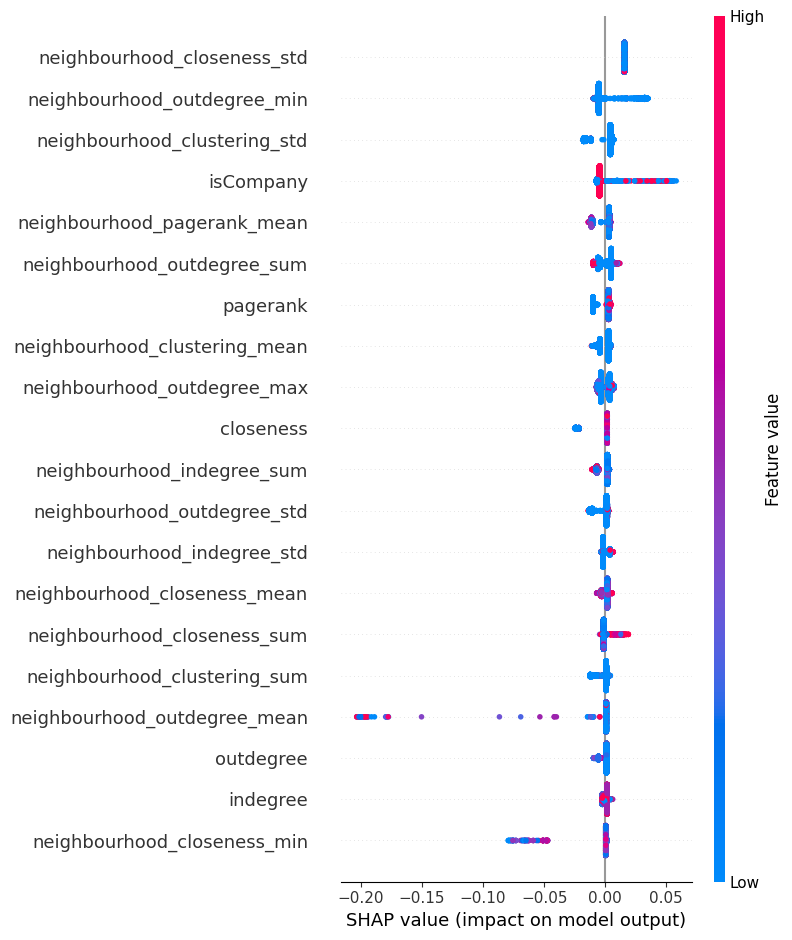

In [112]:
shap.summary_plot(shap_values, X_test)

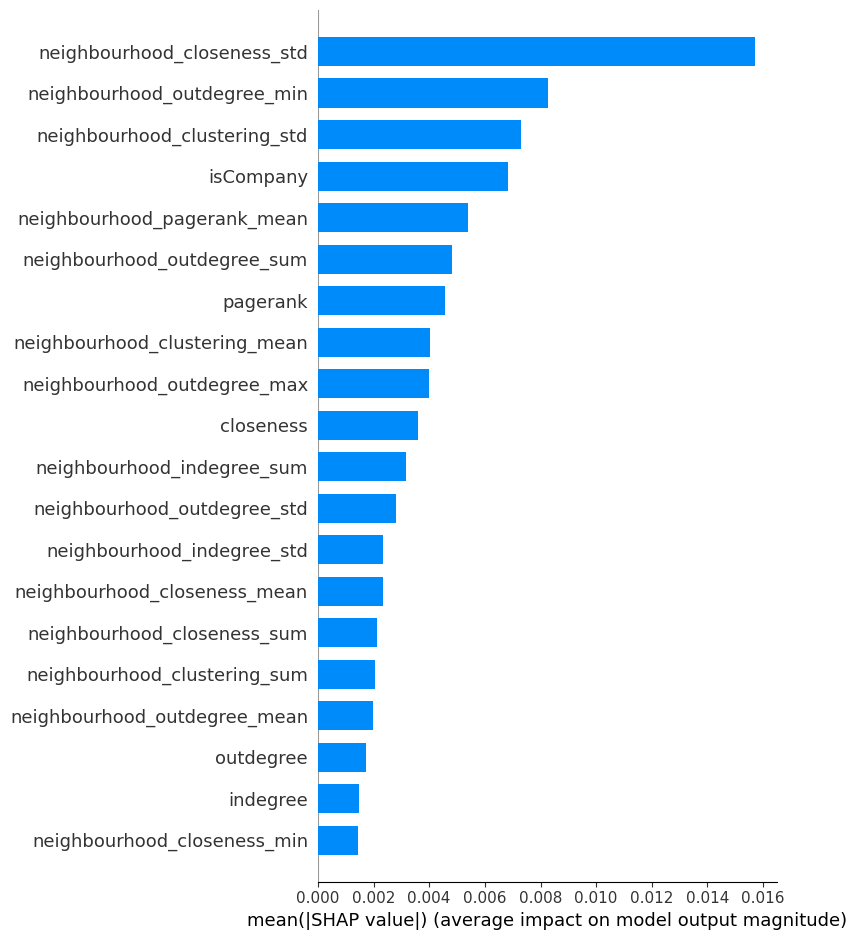

In [113]:
# Plot partial dependence plots.
shap.summary_plot(shap_values, X_test, plot_type="bar")

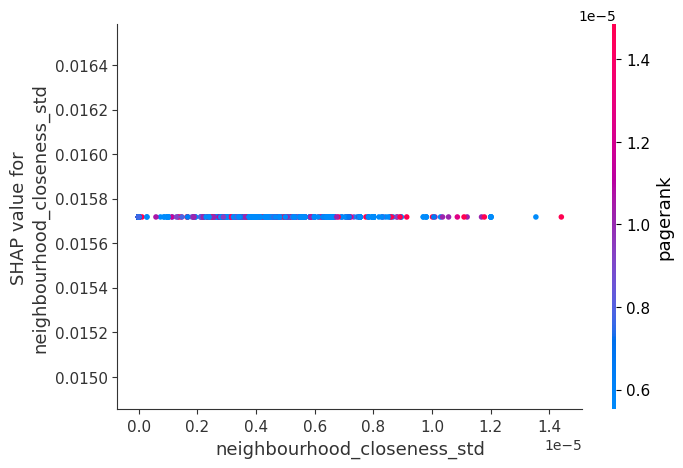

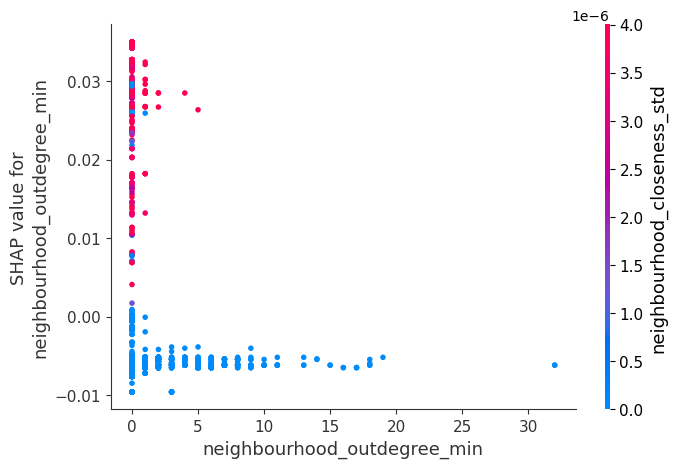

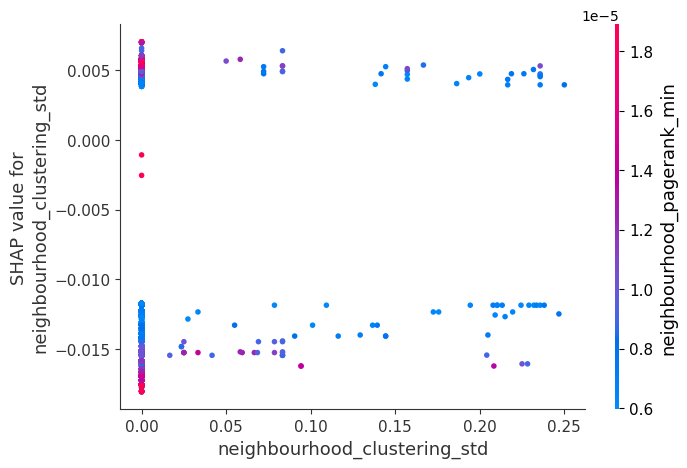

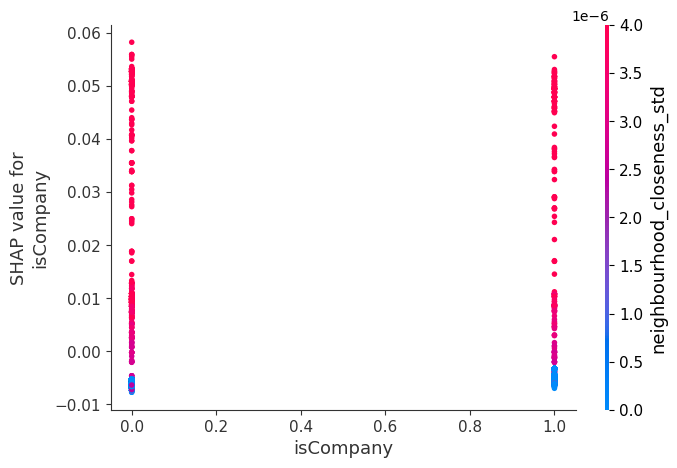

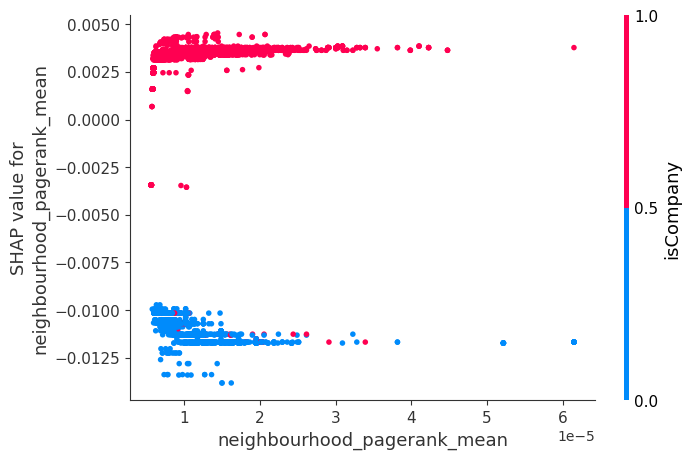

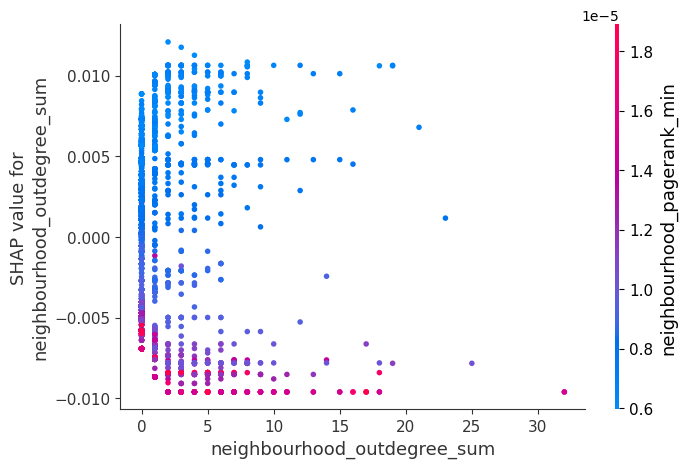

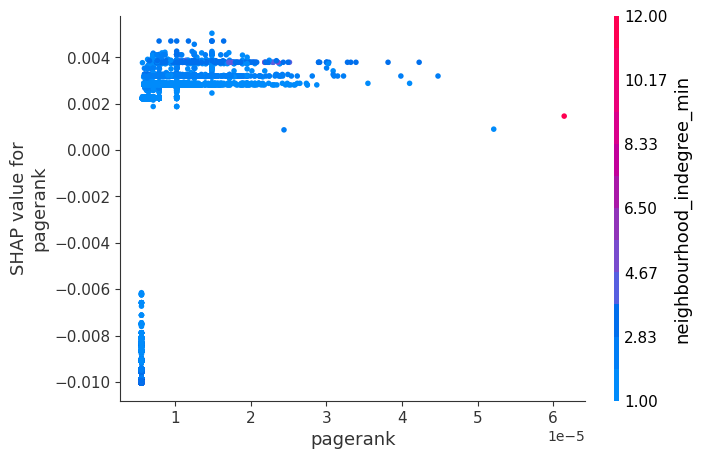

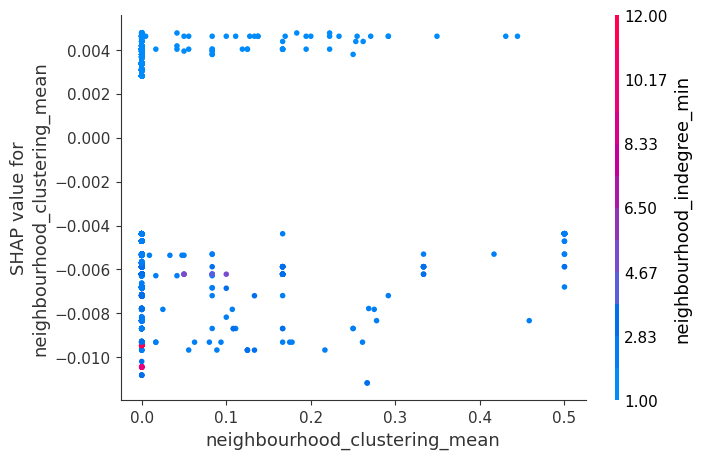

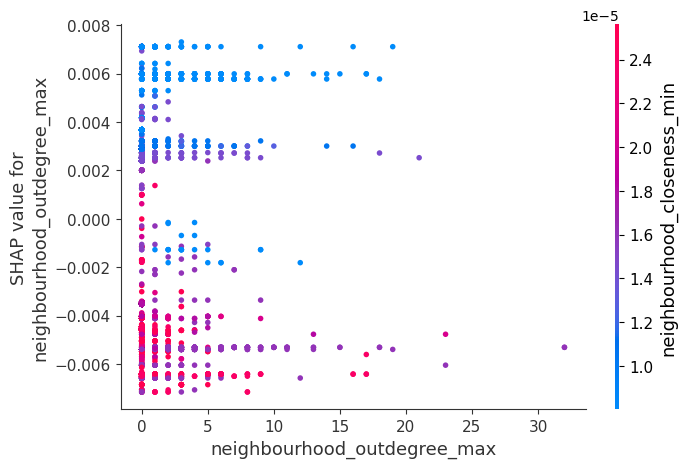

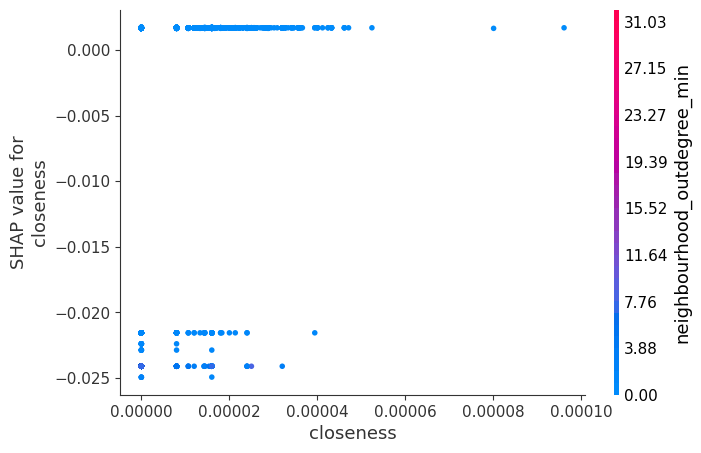

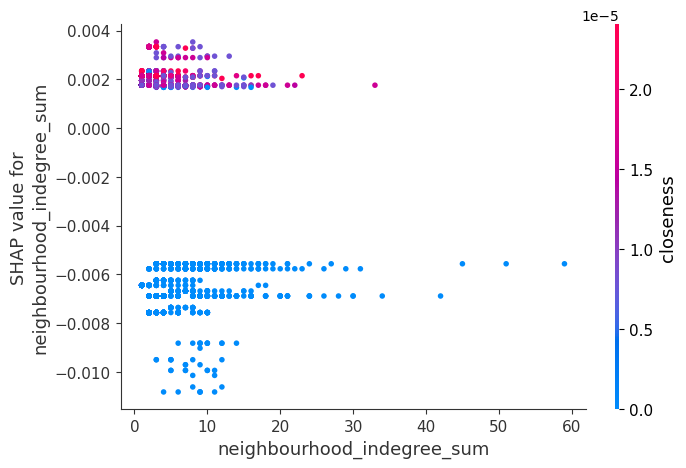

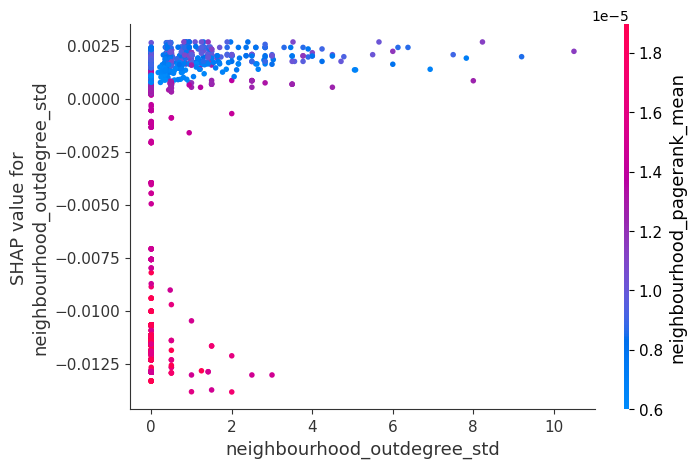

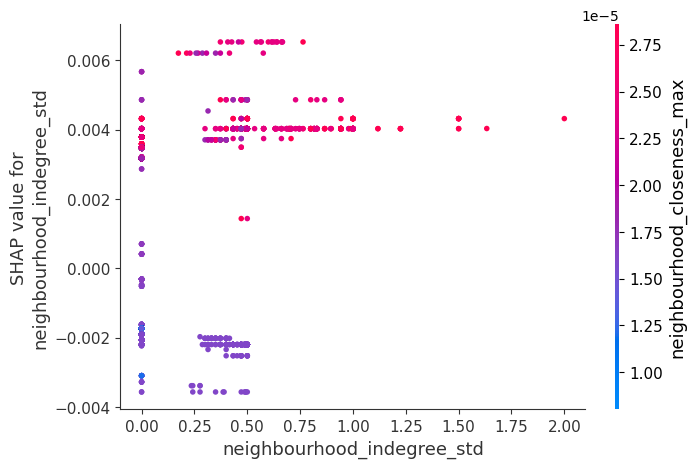

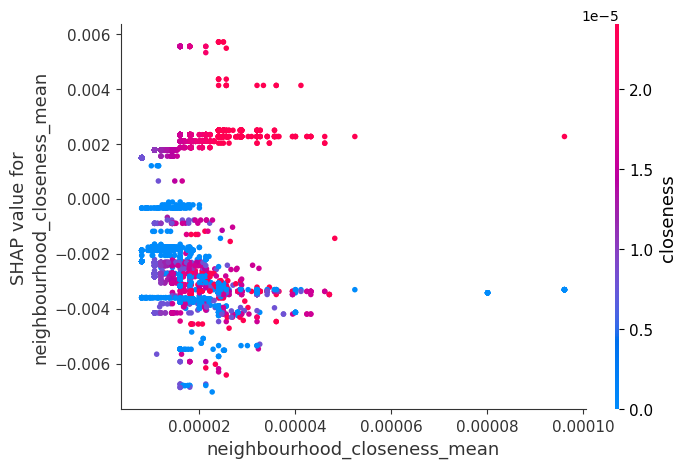

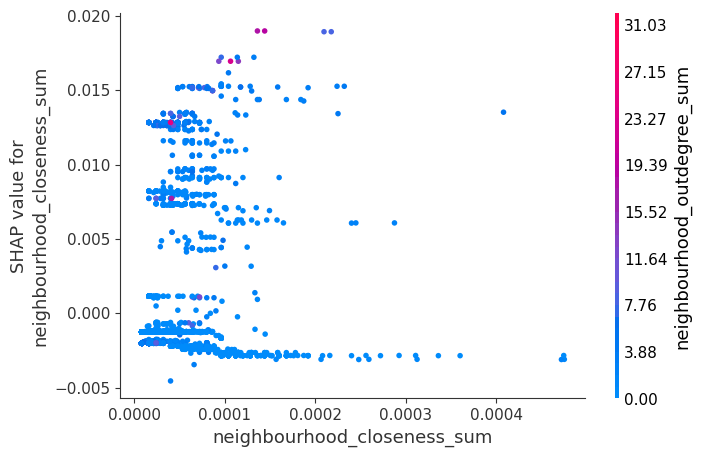

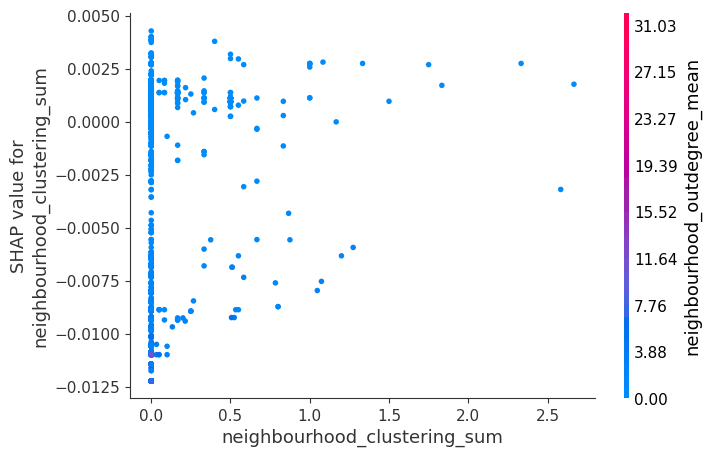

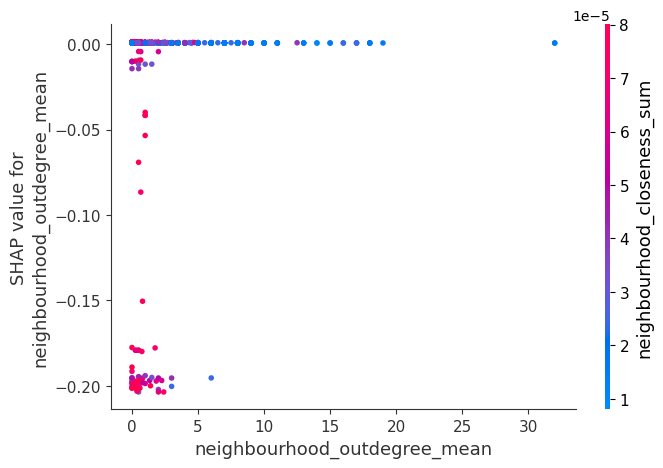

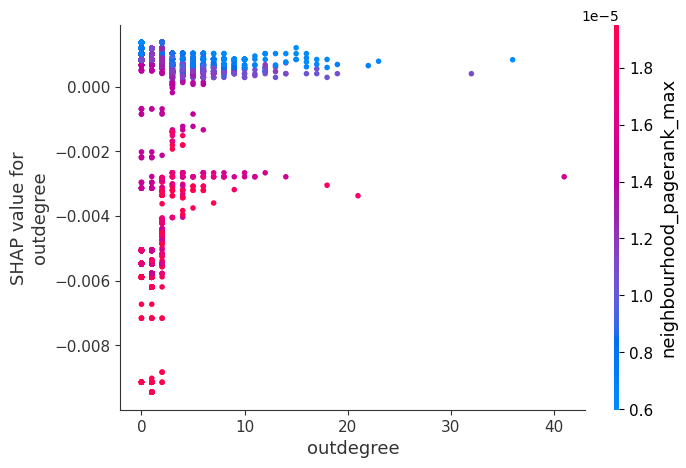

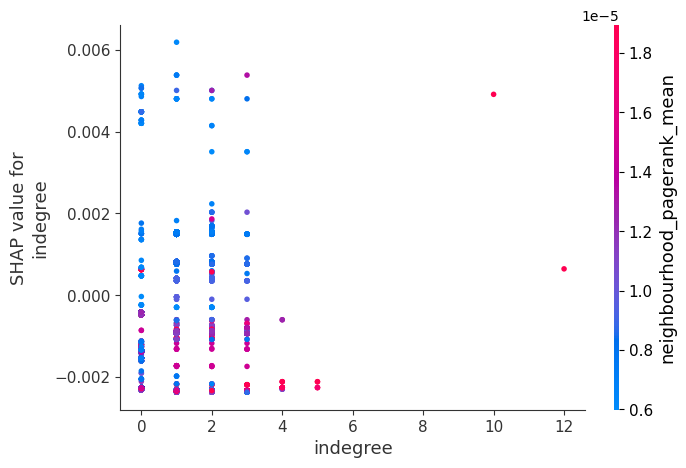

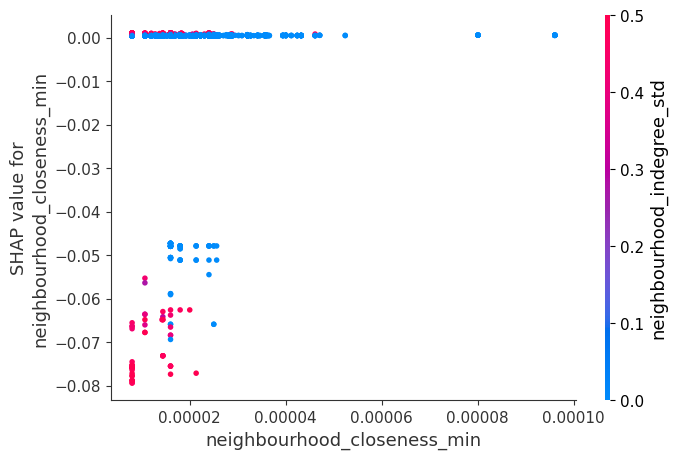

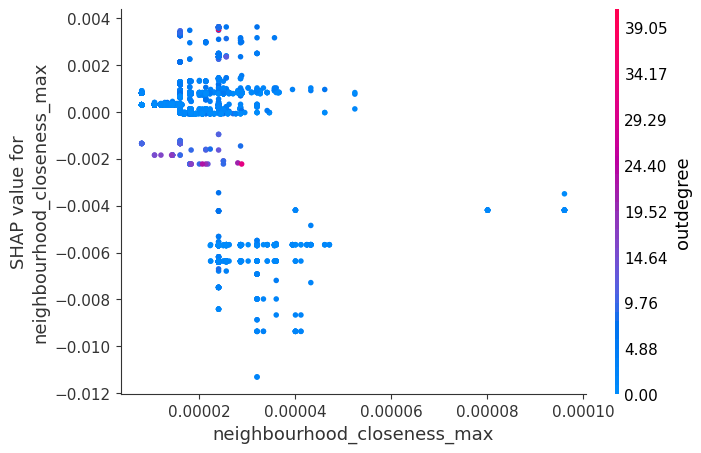

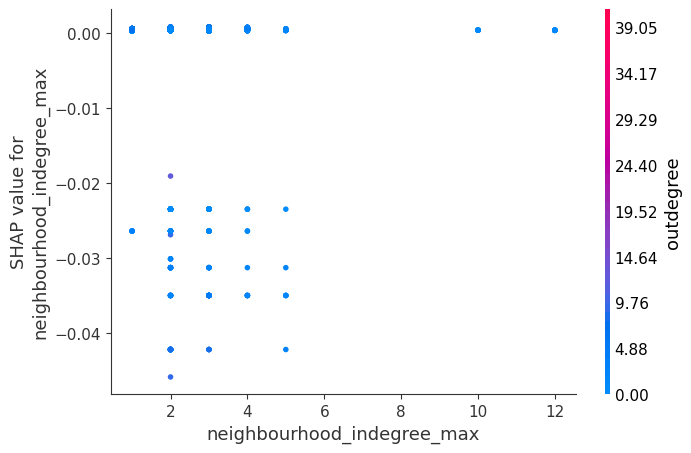

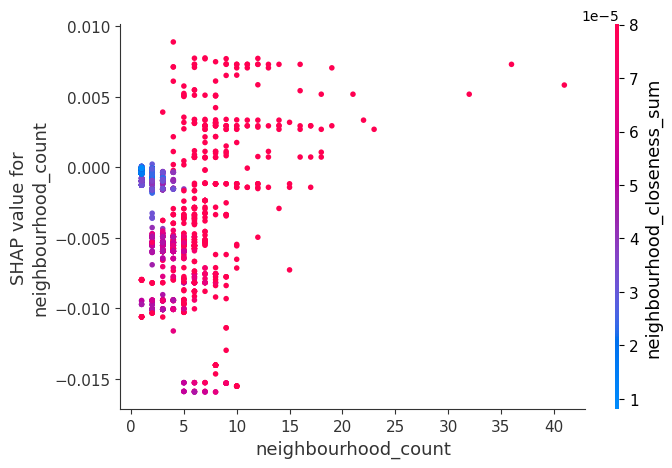

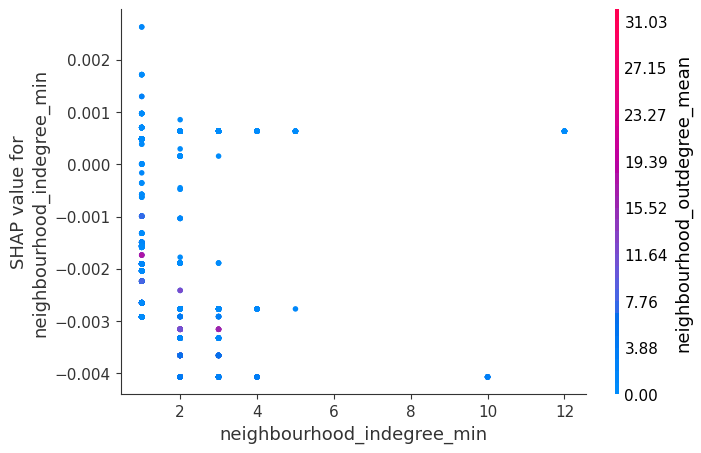

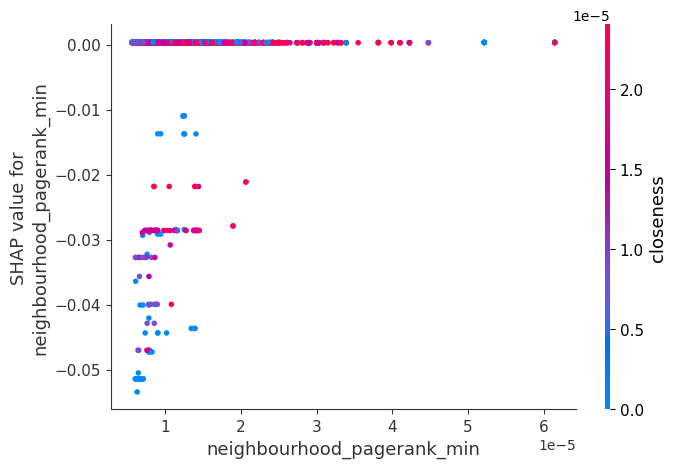

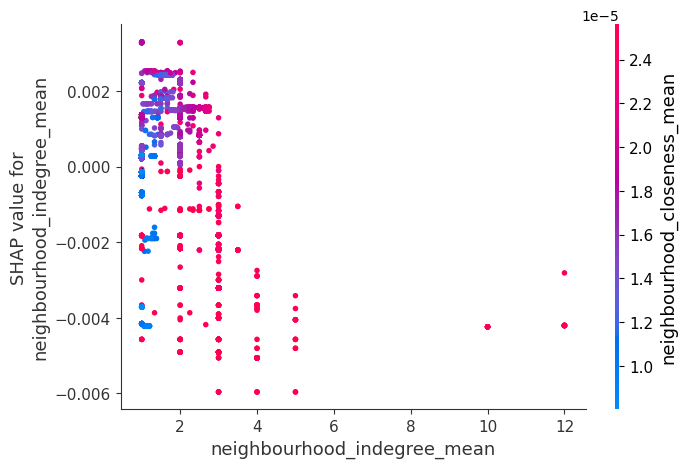

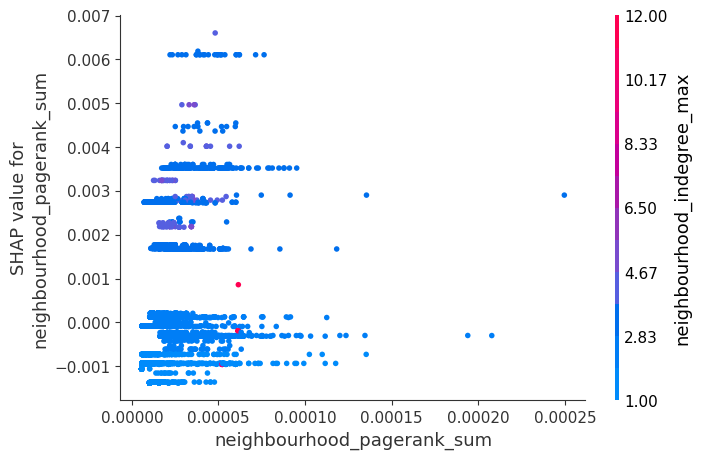

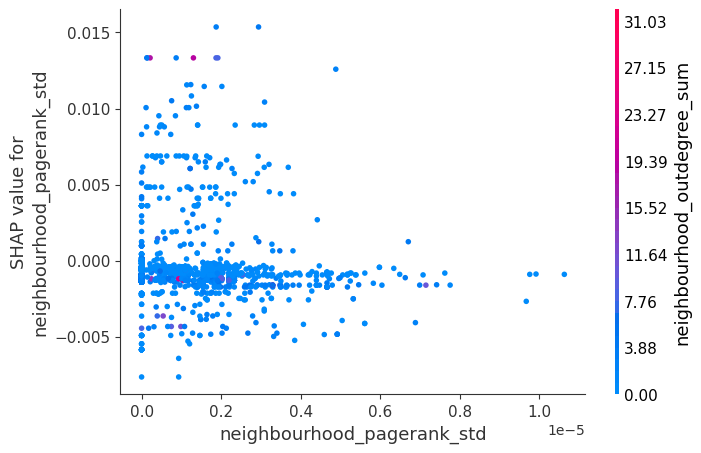

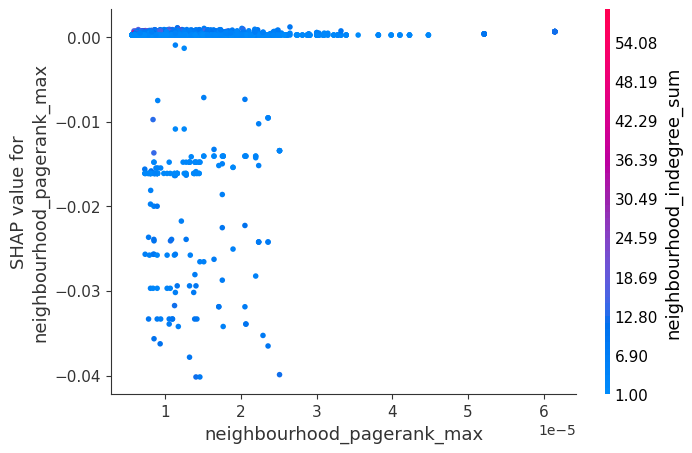

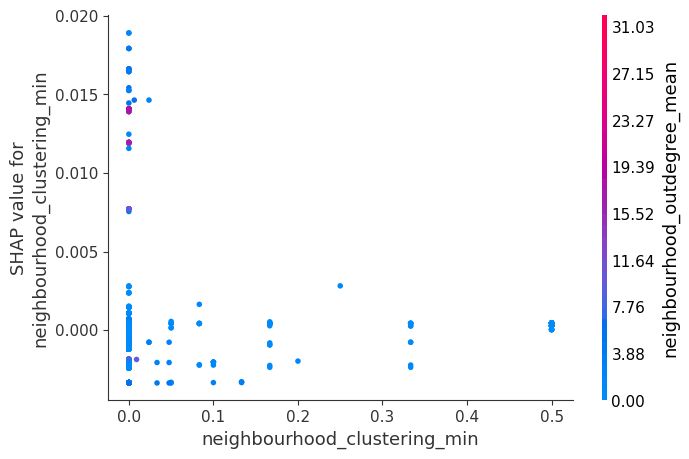

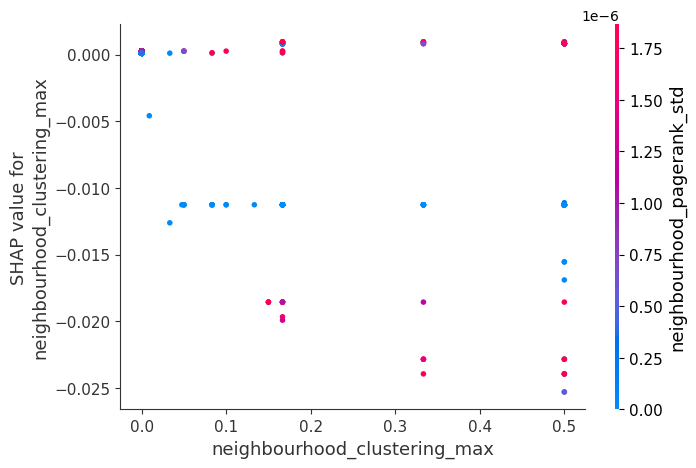

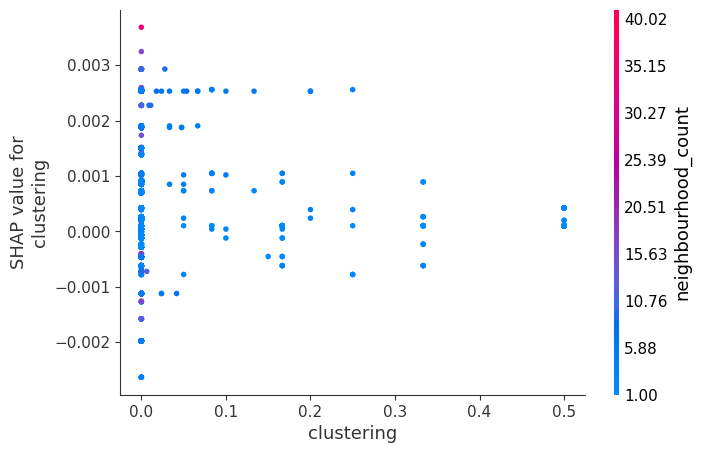

In [114]:
for i in range(X_test.shape[1]):
    shap.dependence_plot(f"rank({i})", shap_values, X_test)
    plt.show()